Columns: Index(['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Chg%'], dtype='object')
         Date  Price   Open   High    Low  Volume  Chg%
0  2024-11-06  77030  78300  78570  77030       0 -1.86
1  2024-11-05  78490  78224  78670  78160       0  0.11
2  2024-11-04  78401  78498  78642  78237       0 -0.54
3  2024-11-01  78829  78650  78887  78550       0  0.64
4  2024-10-31  78326  79264  79999  77803      90 -1.17
ADF p-values: {'Price': np.float64(0.02372101223380091), 'Open': np.float64(0.028003301131263283), 'High': np.float64(0.03361345534305078), 'Low': np.float64(0.02004658012469702), 'Volume': np.float64(0.0004839729492403609), 'Chg%': 0.0}
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        67.80       67.82   2.800e+29       67.81
1        56.84      56.93*   4.865e+24       56.88
2        56.79       56.96   4.616e+24       56.85
3        56.75       56.99   

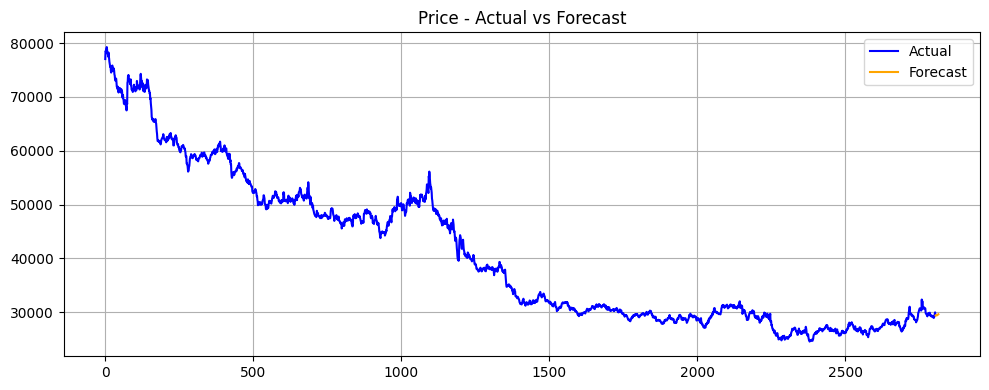

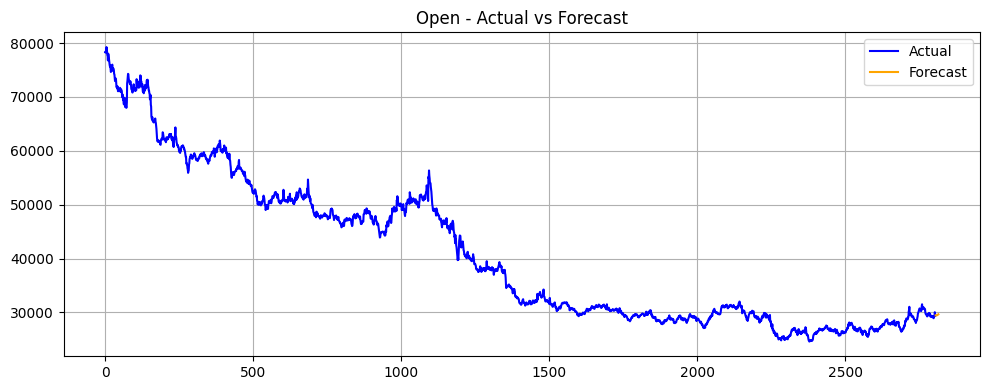

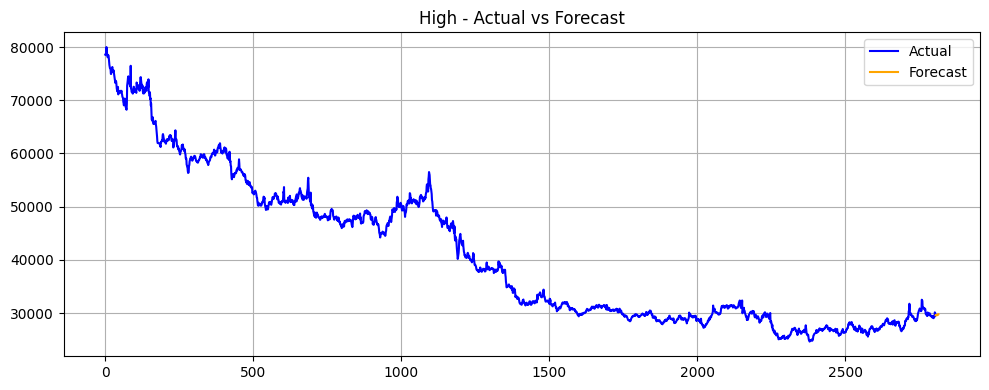

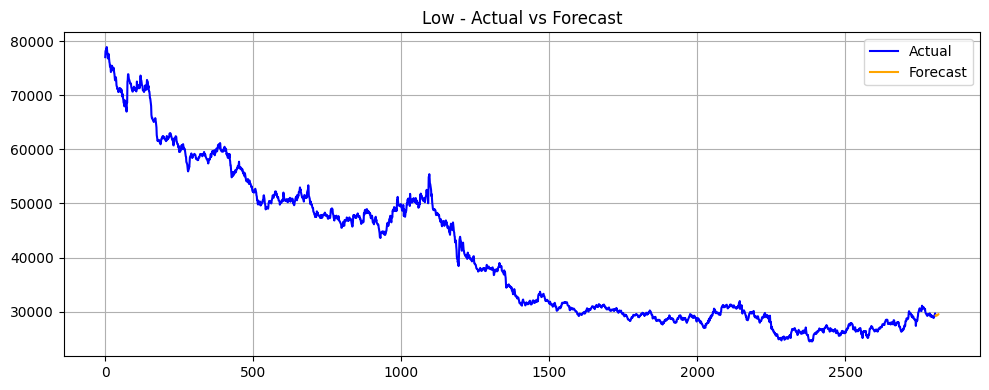

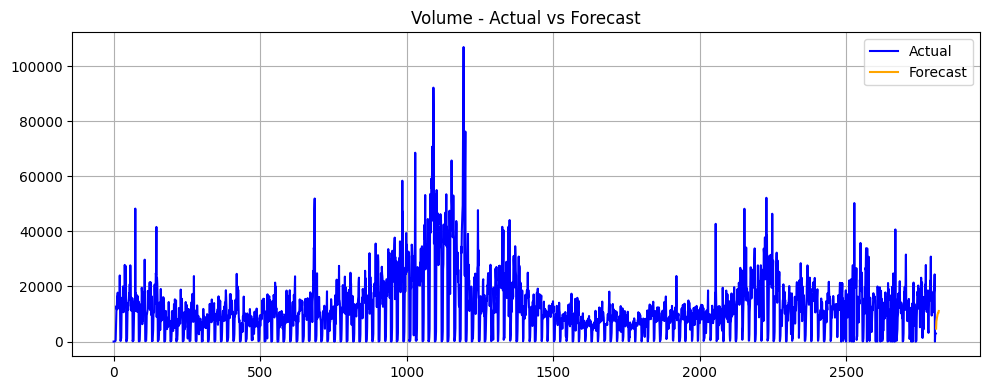

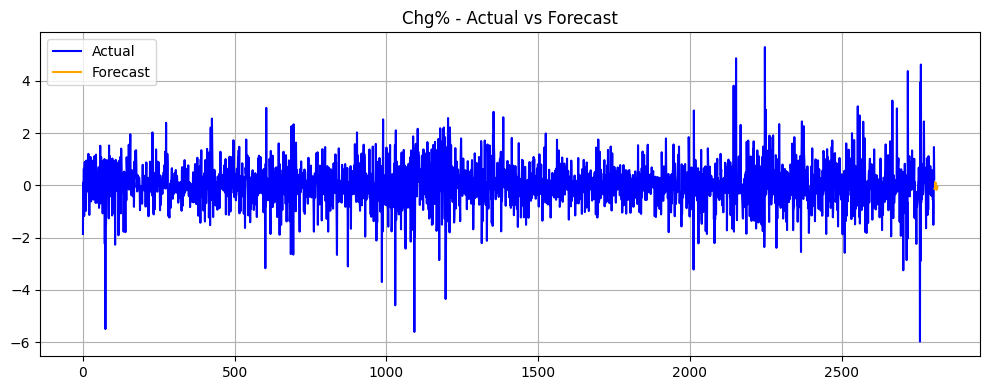

In [1]:
# Install dependencies
!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Upload your file in Colab, or make sure it's in the working directory
df = pd.read_csv('/content/Gold_Price_DataSet (1).csv')

# Show basic info
print("Columns:", df.columns)
print(df.head())

# Keep only numeric columns for VAR
df_numeric = df.select_dtypes(include=[np.number])

# ADF Test for stationarity
def adf_test(series):
    return adfuller(series)[1]

stationarity = {col: adf_test(df_numeric[col]) for col in df_numeric.columns}
print("ADF p-values:", stationarity)

# Apply differencing to non-stationary columns
non_stationary_cols = [col for col, p in stationarity.items() if p > 0.05]
df_diff = df_numeric.copy()
df_diff[non_stationary_cols] = df_diff[non_stationary_cols].diff()
df_diff = df_diff.dropna().reset_index(drop=True)

# Fit VAR model
model = VAR(df_diff)
lag_order = model.select_order(maxlags=15)
print(lag_order.summary())

best_lag = lag_order.aic
var_model = model.fit(best_lag)
print(var_model.summary())

# Forecast next 10 time steps
n_forecast = 10
forecast_input = df_diff.values[-best_lag:]
forecast = var_model.forecast(y=forecast_input, steps=n_forecast)
forecast_df = pd.DataFrame(forecast, columns=df_diff.columns)
forecast_df.index = range(len(df_diff), len(df_diff) + n_forecast)

# If differenced, reconstruct forecast for those columns
for col in non_stationary_cols:
    last_val = df_numeric[col].iloc[-1]
    forecast_df[col] = forecast_df[col].cumsum() + last_val

# Plot actual vs forecast
for col in df_diff.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df_diff[col], label='Actual', color='blue')
    plt.plot(forecast_df[col], label='Forecast', color='orange')
    plt.title(f'{col} - Actual vs Forecast')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
